In [1]:
from sklearn.datasets import load_iris

iris = load_iris()


In [2]:
print(iris.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [3]:
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

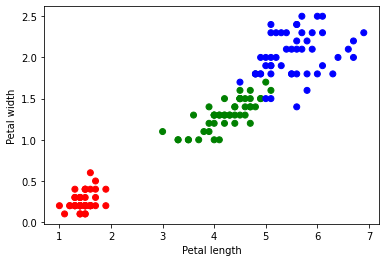

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

petal_length = iris['data'][:, 2]
petal_width = iris['data'][:, 3]
target = iris['target']
colors = ['red','green', 'blue']
plt.xlabel("Petal length")
plt.ylabel("Petal width")
# plot the data for visualization
plt.scatter(petal_length, petal_width, c=target, cmap=matplotlib.colors.ListedColormap(colors))

In [5]:
# Given a threshold value, computes the CART algo cost function by summing weighted gini impurities on each side of the threshold
def compute_cart_cost(x, target, threshold):
    m = len(target)
    left_indices = np.where(x <= threshold)
    right_indices = np.where(x > threshold)
    left_targets = target[left_indices]
    right_targets = target[right_indices]
    left_samples_count = len(left_targets)
    right_samples_count = len(right_targets)
    left_gini = 0
    right_gini = 0
    if (left_samples_count > 0) :
        classes = np.unique(left_targets)
        sample_size = len(left_targets)
        classes = np.unique(left_targets)
        left_gini = 1
        for clazz in classes:
            occurrences = len(np.where(left_targets == clazz)[0])
            left_gini = left_gini - (occurrences * 1.0 / sample_size) ** 2
    if (right_samples_count > 0):
        classes = np.unique(right_targets)
        sample_size = len(right_targets)
        classes = np.unique(right_targets)
        right_gini = 1
        for clazz in classes:
            occurrences = len(np.where(right_targets == clazz)[0])
            right_gini = right_gini - (occurrences * 1.0 / sample_size) ** 2
    cart_cost = left_samples_count / m * left_gini + right_samples_count / m * right_gini
    return cart_cost
    
    

# returns the the threshold yielding the smallest Gini impurity as well as the associated gini impurity
def binary_search(x, target, left, right, iterations, previous_min_cost):
    bs_mid = (left + right) / 2
    bs_bottom = left
    bs_top = right
    mid_gini = compute_cart_cost(x, target, bs_mid)
    cart_costs = [compute_cart_cost(x, target, bs_bottom), mid_gini, compute_cart_cost(x, target, bs_top)]
    local_cart_cost_min = np.amin(cart_costs)
    if (iterations == 0):
        return (bs_mid, mid_gini)
    previous_min_cost = local_cart_cost_min
    if (cart_costs[0] < cart_costs[2]): # recurse on bottom half
        return binary_search(x, target, bs_bottom, bs_mid, iterations - 1, previous_min_cost)
    else:
        return binary_search(x, target, bs_mid, bs_top, iterations - 1, previous_min_cost)
        
# Computes the Gini impurity of an array of target values.
def compute_node_gini(target):
    sample_size = len(target)
    classes = np.unique(target)
    res = 1
    for clazz in classes:
        occurrences = len(np.where(target == clazz)[0])
        res = res - (occurrences * 1.0 / sample_size) ** 2
    return res
    

In [6]:

class CARTNode:
    """This class represents a CART (classification and regression tree) node.
    
    A tree is a recursive data structure by definition and a full CART tree can therefore be described by its root.
    Each tree node has the following instance variables:
        left: A reference to its left child
        right: A reference to its right child
        threshold: The threshold value relative to a given feature to decide whether to recurse on the left or right subtree.
        gini: The Gini impurity for that node
        feature_index: the index of the feature used to make a decision (using threshold defined above)
        clazz: The class this node predicts (if any: A node only predicts a class if it's a leaf)
    """

    def __init__(self, left, right, threshold, gini, feature_index, clazz = None):
        self.left = left # the left tree
        self.right = right 
        self.threshold = threshold # the threshold under it, go to left tree, otherwise go to right tree
        self.gini = gini # the gini impurity for that node.
        self.feature_index = feature_index # which feature this node will do the comparison on.
        self.clazz = clazz # the class this node would predict in case it's a leaf
        
    def predict(self, x):
        if self.clazz is not None:
            return self.clazz
        if x[self.feature_index] <= self.threshold:
            return self.left.predict(x)
        else:
            return self.right.predict(x)
        
            

In [7]:
def build_decision_tree(depth, X, y):
    print("Building tree at level {}".format(depth))
    num_of_features = len(X[0])
    node_gini = compute_node_gini(y)
    print("This node's gini impurity is {}".format(node_gini))
    if node_gini == 0 or depth == 0: # this node is terminal
        print("Found pure terminal leaf")
        clazz = y[0]
        return CARTNode(None, None, None, 0, None, clazz)
    thresholds_and_ginis_by_feature = []
    for feature in range(num_of_features):
        min_feature_value = np.amin(X[:, feature])
        max_feature_value = np.amax(X[:, feature])
        mid_value = binary_search(X[:, feature], y, min_feature_value, max_feature_value, 20, -1)
        thresholds_and_ginis_by_feature.append((feature,) + mid_value)
    min_gini_threshold = min(thresholds_and_ginis_by_feature, key = lambda t: t[2])
    optimal_feature_index = min_gini_threshold[0]
    optimal_threshold = min_gini_threshold[1]
    lowest_cost = min_gini_threshold[2]
    left_indices = np.where(X[:, optimal_feature_index] <= optimal_threshold)
    right_indices = np.where(X[:, optimal_feature_index] > optimal_threshold)
    left_features = X[left_indices]
    right_features = X[right_indices]
    if len(left_features) == 0 or len(right_features) == 0:
        # Could not split sample, probably because they all have the same features
        return handle_inseparable_samples(X, y)
    left = build_decision_tree(depth - 1, left_features, y[left_indices])
    right = build_decision_tree(depth - 1, right_features, y[right_indices])
    root = CARTNode(left, right, optimal_threshold, node_gini, optimal_feature_index)
    return root

# Returns a leaf for the most likely class
# Otherwise this will cause issues when recursing on empty subtrees
def handle_inseparable_samples(X, y):
    print("Handling inseparable samples")
    print(X)
    most_common_class =  np.argmax(np.bincount(y))
    gini_impurity = compute_node_gini(y)
    return CARTNode(None, None, None, gini_impurity, None, most_common_class)


In [8]:
petal_length = iris['data'][:, 2]
petal_width = iris['data'][:, 3]
X = np.stack((petal_length, petal_width), axis=1) # stack along dimension 1 (columns)
target = iris['target']
tree = build_decision_tree(4, X, target)


Building tree at level 4
This node's gini impurity is 0.6666666666666665
Building tree at level 3
This node's gini impurity is 0.0
Found pure terminal leaf
Building tree at level 3
This node's gini impurity is 0.5
Building tree at level 2
This node's gini impurity is 0.1680384087791495
Building tree at level 1
This node's gini impurity is 0.0
Found pure terminal leaf
Building tree at level 1
This node's gini impurity is 0.3106508875739644
Building tree at level 0
This node's gini impurity is 0.10493827160493831
Found pure terminal leaf
Building tree at level 0
This node's gini impurity is 0.5
Found pure terminal leaf
Building tree at level 2
This node's gini impurity is 0.04253308128544431
Building tree at level 1
This node's gini impurity is 0.4444444444444444
Handling inseparable samples
[[4.8 1.8]
 [4.8 1.8]
 [4.8 1.8]]
Building tree at level 1
This node's gini impurity is 0.0
Found pure terminal leaf


In [9]:
print(tree.predict([2, 0.5]))

0


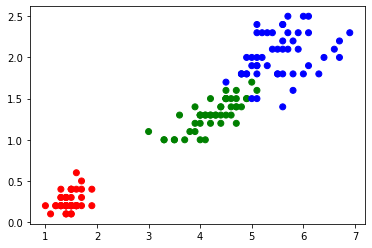

In [10]:
# replotting for ease of visualization
plt.scatter(petal_length, petal_width, c=target, cmap=matplotlib.colors.ListedColormap(colors))

In [11]:
# Some predictions
print(tree.predict([2, 0.5]))
print(tree.predict([1.2, 2]))
print(tree.predict([3, 1]))
print(tree.predict([4.6, 1.5]))
print(tree.predict([4, 2]))
print(tree.predict([6, 2]))

0
0
1
1
2
2
